# Apply EOQ, ROP, TC in case quantity discount model

For product A, Having a number of demand during a year, 250 work days.<br>Inventory in warehouses have 1800 units

Supplier provide discount per unit due to purchase quantity with order condition
* 5.0฿ per unit for purchase 1 - 4 pallet -> not over 4 * 48 * 12 == 2,304 units
* 4.5฿ per unit for purchase 5 - 8 pallet -> not over 8 * 48 * 12 == 4,608 units
* 4.0฿ per unit for purchase over 8 pallet -> more than 4,608 units
* The palett have contain maximum 48 boxes
* The box have contain 12 inventory units
* Minimum order quantity is 1 pallet -- 576 units
* Minimum lot size is 1 box -- 12 units
* each of orders have average 7 days to delivers.

For the operation cost having:
* Set up cost: once order is 300฿
* Holding cost: holding cost 20% of inventory cost per units

Question:
1. Consider to EOQ of each price, 5฿, 4.5฿, 4฿. Did EOQ from case is true?<br>
2. Based on total cost, how many units should orders with minimum cost?

In [1]:
import math, random, datetime
import os, openpyxl
import scipy.stats as stats
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.style.use("tableau-colorblind10")
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["figure.dpi"] = 100

import warnings
warnings.filterwarnings('ignore')

In [2]:
from MinimumLotSize import LotSize as lot
from SafetyStock import SafetyStock as sts
from ReOrderPoint import ROP as rop
from EconomicOrderQuantity import EOQ, impact_ratio
from TotalCost import TC as ttc

assert impact_ratio(29.12, 32, True) == 0.1112
assert sts.normdist(Demand=500, Leadtime=3, service_level=90) == 0

done


## Data

In [3]:
file_path = "data.xlsx"
demand_df = pd.read_excel(file_path, engine='openpyxl',
                          header=0,usecols="A")
print("Demand profile:")
demand_df.describe().round(2).T

Demand profile:


,count,mean,std,min,25%,50%,75%,max
demand,250.0,100.1,7.94,73.0,95.25,100.0,106.0,119.0


In [4]:
# Plot data profile func 
def plot_data_profile(data, label):
    fig_profile, axs = plt.subplots(2)
    axs[0].plot(data, label=label, c="#979797")
    axs[0].axhline(y=data.mean(), c = "g", ls="--", label=f"average {label}")
    axs[0].set_title(f"Dynamic of {label}")
    axs[0].legend(loc=1);
    axs[1].hist(data, color ="#979797")
    axs[1].set_title(f"Frequence of {label}");

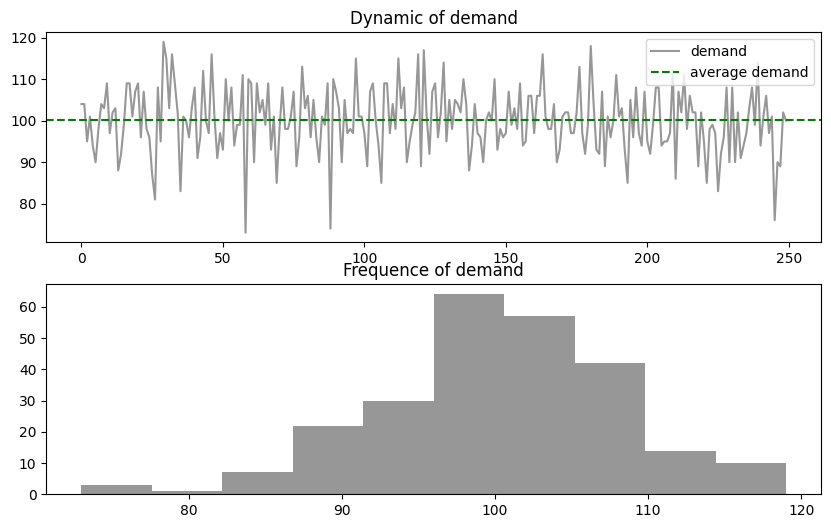

In [5]:
plot_data_profile(demand_df["demand"], label="demand")

In [6]:
# Determine parameter
# Set inventory left in warehouse
stock_zero = 1800

# Set operation cost
setup_c = 300
holding_c = 0.2

# Set discount price and order units
discount_price = {5.0 : 576,
                  4.5 : 2304,
                  4.0 : 4608}

print(f"""
      Work day = {len(demand_df)} days
      Operation Cost:
        - Set up cost = {setup_c}฿
        - Holding cost = {holding_c*100}% of inventory price""");

# Total demand and inventory require
year_demand = demand_df["demand"].sum()
I = year_demand - stock_zero

print("Inventory on hand =", stock_zero)
print(f"Year Demand ({len(demand_df)} days) =",year_demand)
print("Inventory require =", I)


      Work day = 250 days
      Operation Cost:
        - Set up cost = 300฿
        - Holding cost = 20.0% of inventory price
Inventory on hand = 1800
Year Demand (250 days) = 25026
Inventory require = 23226


## Leadtime
- Generate leadtime

In [7]:
# Generate order leadtime from parameter
avg_lt = 4
sd_lt = 1
order_size = 11

leadtime_day = []
random.seed(42)
for i in np.random.normal(loc=avg_lt, scale=sd_lt, size=order_size):
  leadtime_day.append(round(i))

leadtime_days = pd.DataFrame(data={"leadtime":leadtime_day}, index = range(len(leadtime_day)))

print("Leadtime profile:")
leadtime_days.describe().round(2).T

Leadtime profile:


,count,mean,std,min,25%,50%,75%,max
leadtime,11.0,3.55,1.04,2.0,3.0,4.0,4.0,5.0


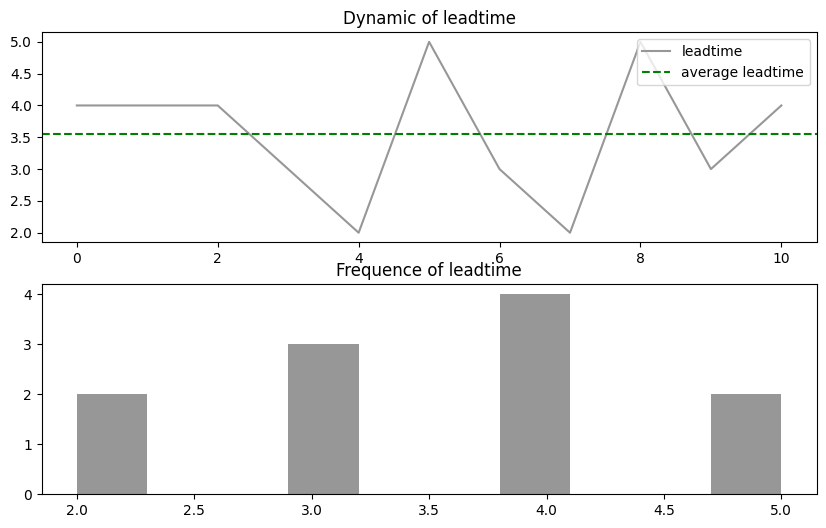

In [8]:
plot_data_profile(leadtime_days["leadtime"], label="leadtime")

## Determine EOQ
To answer question 1, consider economic order quantity for each price is it true:
- eoq of 5.0 between  576 - 2304 unit
- eoq of 4.5 between 2305 - 4608 units
- eoq of 4.0 more than 4608 units

### Perform EOQ for each product price

In [9]:
# Total cost of each price
print("Order with minimum quantity in each price will cost:\n-----")
for price in discount_price:
    print(f"Total cost to order at {discount_price.get(price)} units is", str(ttc(D=I, C=price, S=setup_c, H=holding_c*price, Q=discount_price.get(price)))+"฿")
    print(f"Numbers of order: {math.ceil(I/discount_price.get(price))} orders")
    print("----------")

Order with minimum quantity in each price will cost:
-----
Total cost to order at 576 units is 128514.88฿
Numbers of order: 41 orders
----------
Total cost to order at 2304 units is 108578.02฿
Numbers of order: 11 orders
----------
Total cost to order at 4608 units is 96259.31฿
Numbers of order: 6 orders
----------


In [10]:
print("EOQ at each price")
print("---")
for price in discount_price:
  print(f"Order more than {discount_price.get(price)} units with product price = {price}฿. EOQ =",
        round(EOQ(D = I, S=setup_c, H=holding_c*(price)), 2), "units")
  print("----------");

EOQ at each price
---
Order more than 576 units with product price = 5.0฿. EOQ = 3733.04 units
----------
Order more than 2304 units with product price = 4.5฿. EOQ = 3934.97 units
----------
Order more than 4608 units with product price = 4.0฿. EOQ = 4173.67 units
----------


From eoq in each price, The possible order quantity is in range of 4.5฿

Due to economic order quantity formular did not consider purchase cost due to even purchase more, product price still the same. Let's see total cost using _quantity discount model_ to compare total cost include purchase price.

> Total Cost = Set up cost + Holding cost + Purchase cost

In [11]:
# Campare Total cost in each price
eoq_price = EOQ(D = I, S=setup_c, H=holding_c*4.5)
eoq_ord = lot.round_lot_size( eoq_price, 12)
min_4_ord = discount_price.get(4)
eoq_cost = ttc(D=I, C=4.5, S=setup_c, H=holding_c*4.5, Q=eoq_ord)
minord_cost = ttc(D=I, C=4, S=setup_c, H=holding_c*4, Q=discount_price.get(4))

print(f"Perform EOQ summary:\nEconomic order quantity is {round(eoq_price, 2)} units.\nDue to lot size 12 units, order quantity will be {eoq_ord} units with {math.ceil(I/eoq_ord)} orders.")
print(f"Order at EOQ --{eoq_ord} units cost {eoq_cost}฿ and save {round(minord_cost - eoq_cost,2)}฿\nfrom order at mininmum quantity of minimum price with {min_4_ord - eoq_ord} units lower.")

Perform EOQ summary:
Economic order quantity is 3934.97 units.
Due to lot size 12 units, order quantity will be 3936 units with 6 orders.
Order at EOQ --3936 units cost 108058.47฿ and save -11799.16฿
from order at mininmum quantity of minimum price with 672 units lower.


Purchase at eoq (3936 unite) have total cost more than purchase at minimum price (4608 units).<br>
Let's see if there are smaller total cost by using what-if simulation.

### What-if Analysis

In [12]:
# Inventory cost modeling
# quantity range set up
min_qty = 1 * 48 * 12 # minimum order quantity -> 576 //1 pallet with 48 box and 12 bags init
max_qty = 9 * 48 * 12 # max order quantity -> 5184 // 9 pallet
step_qty = 12 # step increase by minimum lot 12 -> box
    
cost_model = pd.DataFrame()
cost_model["quantity"] = range(min_qty, max_qty+1, step_qty)
cost_model["inv_price"] = cost_model["quantity"].apply(lambda x: 4 if x > discount_price.get(4) else 4.5 if x > discount_price.get(4.5) else 5)

cost_model["inventory_cost"] =   (cost_model["inv_price"]*I).round(2)
cost_model["holding_cost"] = ttc(D=I, C=0, S=0, H=holding_c*cost_model["inv_price"], Q=cost_model["quantity"])
cost_model["setup_cost"] =   ttc(D=I, C=0, S=setup_c, H=0, Q=cost_model["quantity"])

cost_model["operation_cost"] = cost_model["holding_cost"] + cost_model["setup_cost"]
cost_model["TC"] = (cost_model["inventory_cost"] + cost_model["holding_cost"] + cost_model["setup_cost"]).round(2)

In [13]:
print(f"""
    What-if analysis
    simulation parameter
        Start order unit: {min_qty} units
        Stop order unit: {max_qty} units
        Increase unit: {step_qty} units""")
cost_model


    What-if analysis
    simulation parameter
        Start order unit: 576 units
        Stop order unit: 5184 units
        Increase unit: 12 units


,quantity,inv_price,inventory_cost,holding_cost,setup_cost,operation_cost,TC
0,576,5.0,116130.0,288.0,12096.88,12384.88,128514.88
1,588,5.0,116130.0,294.0,11850.00,12144.00,128274.00
2,600,5.0,116130.0,300.0,11613.00,11913.00,128043.00
3,612,5.0,116130.0,306.0,11385.29,11691.29,127821.29
4,624,5.0,116130.0,312.0,11166.35,11478.35,127608.35
...,...,...,...,...,...,...,...
380,5136,4.0,92904.0,2054.4,1356.66,3411.06,96315.06
381,5148,4.0,92904.0,2059.2,1353.50,3412.70,96316.70
382,5160,4.0,92904.0,2064.0,1350.35,3414.35,96318.35
383,5172,4.0,92904.0,2068.8,1347.22,3416.02,96320.02


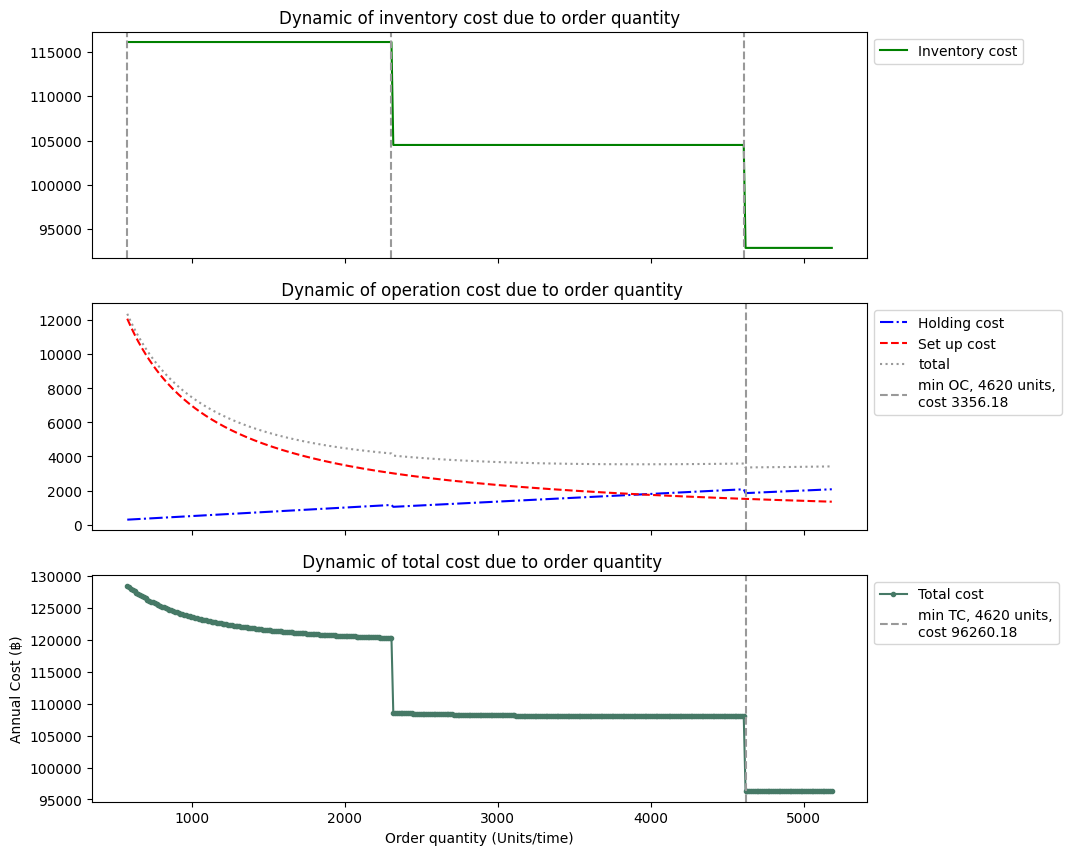

In [14]:
# order quantity cost plot
min_tc_cost = min(cost_model["TC"])
min_tc = cost_model[cost_model["TC"] == min_tc_cost]["quantity"].min()

min_oc_cost = min(cost_model["operation_cost"])
min_oc = cost_model[cost_model["operation_cost"] == min_oc_cost]["quantity"].min()

# Plot model
fig_cost, axs = plt.subplots(3, figsize=(10, 10), sharex=True)
axs[0].plot(cost_model["quantity"], cost_model["inventory_cost"], label="Inventory cost", c = "g", ls = "-")
for i in discount_price:
  axs[0].axvline(x=discount_price.get(i), c = "#999999", ls="--")
axs[0].set_title("Dynamic of inventory cost due to order quantity")
axs[0].legend(bbox_to_anchor=(1.0, 1.0),loc=2)

axs[1].plot(cost_model["quantity"], cost_model["holding_cost"], label="Holding cost", c = "b", ls = "-.")
axs[1].plot(cost_model["quantity"], cost_model["setup_cost"], label="Set up cost", c = "r", ls = "--")
axs[1].plot(cost_model["quantity"], cost_model["operation_cost"], label="total",c = "#999999", ls = ":")
axs[1].axvline(x=min_oc, c = "#999999", ls="--", label = f"min OC, {min_oc} units,\ncost {round(min_oc_cost, 2)}")
axs[1].set_title("\n Dynamic of operation cost due to order quantity")
axs[1].legend(bbox_to_anchor=(1.0, 1.0),loc=2)

axs[2].plot(cost_model["quantity"], cost_model["TC"], label="Total cost", c="#467966", ls="-", marker='.')
axs[2].axvline(x=min_tc, c = "#999999", ls="--", label = f"min TC, {min_tc} units,\ncost {round(min_tc_cost, 2)}")
axs[2].set_title("\n Dynamic of total cost due to order quantity")
axs[2].legend(bbox_to_anchor=(1.0, 1.0),loc=2)

plt.xlabel("Order quantity (Units/time)")
plt.ylabel("Annual Cost (฿)");

In [15]:
# Model with minimum total cost
print("Minimum cost model:")
cost_model[cost_model["TC"] == cost_model["TC"].min()]

Minimum cost model:


,quantity,inv_price,inventory_cost,holding_cost,setup_cost,operation_cost,TC
337,4620,4.0,92904.0,1848.0,1508.18,3356.18,96260.18


In [16]:
save_eoq = round((cost_model[cost_model["quantity"] == lot.round_lot_size(x=eoq_ord, min_size=step_qty) ]["TC"].max() - min_tc_cost),2)
print(f"From cost model, order at {min_tc} units can save {save_eoq}฿ from order at EOQ--{eoq_ord} units." )
print(f"Cost impact is {impact_ratio(eoq_cost, minord_cost, True, 2)}% with {impact_ratio(eoq_ord, min_4_ord, True, 2)}% unit changes")

From cost model, order at 4620 units can save 11798.29฿ from order at EOQ--3936 units.
Cost impact is 0.17% with 0.31% unit changes


## Determine ROP

In [17]:
# prepare data for simulation
zero = pd.DataFrame(data=[0], index=[0])
plan_df = pd.concat([zero, demand_df['demand']], ignore_index=True)
plan_df.columns = ["demand"]
leadtime_df = pd.concat([zero, leadtime_days["leadtime"]], ignore_index=True, )
leadtime_df.columns = ["leadtime"]

In [18]:
# Simulate inventory level with Re-Order Point and Fixed Order Quantity
model_sl = 0.95
df = plan_df.copy()

model_lt = math.ceil(leadtime_days["leadtime"].mean())
model_ss = math.ceil(sts.normdist(demand_df["demand"], leadtime_days["leadtime"], model_sl))
model_rop = math.ceil(rop(demand_df["demand"], Leadtime=leadtime_days["leadtime"], Safety_Stock = model_ss))
product_price = 4
# Create a new column 'on_hand' with initial stock
df['on_hand'] = stock_zero
df['rop_check'] = False
df['order_arrive'] = 0
df['onhand_cost'] = 0

onhand = []
ropcheck = []
order_arr = []

# loop calculate
for i in df.index:

  l_index = int(sum(df['rop_check'][:i]))
  leadtime = int(leadtime_df.loc[l_index, ["leadtime"]])

  # Check if order arrive -> if rop.shift(leadtime) == True then onhand + order qty
  if i < model_lt:
    order_arr.append(0)
  elif df["rop_check"][i - leadtime] == True:
    order_arr.append(min_tc)
  else:
    order_arr.append(0)
  df['order_arrive'][i] = order_arr[i]

  # calculate on-hand unit after use in demand and order arrive
  if i == 0:
    onhand.append(stock_zero)
  else:
    onhand.append(df["on_hand"][i-1]  - df["demand"][i] + df['order_arrive'][i])
  df["on_hand"][i] = onhand[i]
  df['onhand_cost'][i] = max(df["on_hand"][i]*product_price ,0)

  # Check left onhand, if it less than rop check if there are an order before orders
  if (df["on_hand"][i] <= model_rop) & (sum(ropcheck[i-leadtime : i]) == 0):
    ropcheck.append(True)
  else:
    ropcheck.append(False)
  df["rop_check"][i] = ropcheck[i]

print(f"Re-Order Poing and Safety stock at service level {model_sl*100}%\nROP =", model_rop, "units\nSafety Stock =", model_ss,"units")

Re-Order Poing and Safety stock at service level 95.0%
ROP = 520 units
Safety Stock = 165 units


In [19]:
print("Sample of simulation (last 14 day):")
df.tail(14).T

Sample of simulation (last 14 day):


,237,238,239,240,241,242,243,244,245,246,247,248,249,250
demand,103,108,99,114,94,101,106,97,101,76,90,89,102,100
on_hand,1151,1043,944,830,736,635,529,432,331,255,165,76,4594,4494
rop_check,False,False,False,False,False,False,False,True,False,False,False,False,False,False
order_arrive,0,0,0,0,0,0,0,0,0,0,0,0,4620,0
onhand_cost,4604,4172,3776,3320,2944,2540,2116,1728,1324,1020,660,304,18376,17976


## Model summary

In [20]:
inv_end = df.iloc[-1, 1]
turn_over = round(df["demand"].sum()/((stock_zero+inv_end)/2), 2)
inv_day = round(len(demand_df)/turn_over, 2)
inv_avg = (df["on_hand"].mean()).round(2)
inv_cost_avg = round( df['onhand_cost'].mean(),2)
orderss = df["rop_check"].sum()
loss_sale = ((df[df["on_hand"] <= 0]["on_hand"].count())/len(demand_df)).round(4)
max_index = df[df["order_arrive"]>0].index.to_list()
min_index = [x-1 for x in max_index]
avg_min_onhand = round(df.loc[min_index,"on_hand"].mean(),2)
avg_max_onhand = round(df.loc[max_index,"on_hand"].mean(),2)

print(f"Re-Order Poing and Safety stock at service level {model_sl*100}%:\nROP =", model_rop,"units\nSafety Stock =", model_ss,"units")
print(f"Number of order = {orderss} orders")
print("----------")
print(f"Inventory report:\nInventory in the end of period: {inv_end} units")
print(f"Inventory turn over = {turn_over} cycle")
print(f"Inventory day = {inv_day} days")
print("----------")
print(f"Average maximum inventory carry = {avg_max_onhand} units")
print(f"Average minimum inventory carry = {avg_min_onhand} units")
print(f"Average inventory on-hand carry = {inv_avg} units")
print(f"Average inventory cost carry = {inv_cost_avg}฿")
print("----------")
print(f"Loss sale ratio = {loss_sale*100}%")
df[df["on_hand"] <= 0].iloc[:,[0,1,3,4]]

Re-Order Poing and Safety stock at service level 95.0%:
ROP = 520 units
Safety Stock = 165 units
Number of order = 6 orders
----------
Inventory report:
Inventory in the end of period: 4494 units
Inventory turn over = 7.95 cycle
Inventory day = 31.45 days
----------
Average maximum inventory carry = 4731.33 units
Average minimum inventory carry = 215.67 units
Average inventory on-hand carry = 2390.95 units
Average inventory cost carry = 9563.81฿
----------
Loss sale ratio = 0.0%


,demand,on_hand,order_arrive,onhand_cost


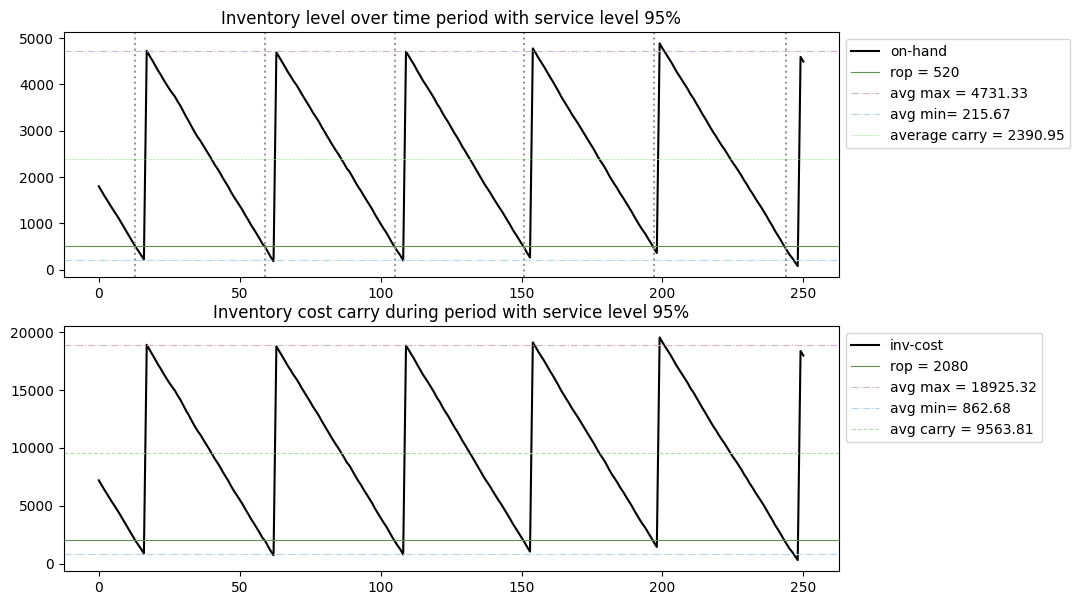

In [21]:
# @markdown Inventory level model plot ls=95%
fig, axs = plt.subplots(2, figsize=(10, 7))

axs[0].plot(df["on_hand"], label="on-hand", c='k')
axs[0].axhline(y=model_rop, label=f"rop = {model_rop}", c='#659053', ls='-', lw=0.8)
axs[0].axhline(y= avg_max_onhand, label=f"avg max = {avg_max_onhand}", c='#d1b4ce', ls='-.', lw=0.8)
axs[0].axhline(y= avg_min_onhand, label=f"avg min= {avg_min_onhand}", c='#b6d5eb', ls='-.', lw=0.8)
axs[0].axhline(y=inv_avg , label=f"average carry = {inv_avg}", c='#a8e4a0', ls='--', lw=0.5)
for i in df[df["rop_check"]==True].index:
  axs[0].axvline(x=i,  ymax= 130 ,c='#999999',ls=":")
axs[0].set_title("Inventory level over time period with service level 95%")
axs[0].legend(bbox_to_anchor=(1.0, 1.0),loc=2);

axs[1].plot(df["onhand_cost"], label="inv-cost", c='k', ls="-")
axs[1].axhline(y=model_rop*4, label=f"rop = {model_rop*4}", c='#659053', ls='-', lw=0.8)
axs[1].axhline(y=avg_max_onhand*4, label=f"avg max = {avg_max_onhand*4}", c='#d1b4ce', ls='-.',lw=0.8)
axs[1].axhline(y=avg_min_onhand*4, label=f"avg min= {avg_min_onhand*4}", c='#b6d5eb', ls='-.', lw=0.8)
axs[1].axhline(y=inv_cost_avg, label=f"avg carry = {inv_cost_avg}", c='#a8e4a0', ls='--', lw=0.8)
axs[1].set_title("\nInventory cost carry during period with service level 95%")
axs[1].legend(bbox_to_anchor=(1.0, 1.0),loc=2);

In [22]:
print("Schedule which include the order and order arrive day:");
df[(df['rop_check']==True) | (df["order_arrive"]>0)].replace({True: "order", False: 'arrive'})

Schedule which include the order and order arrive day:


,demand,on_hand,rop_check,order_arrive,onhand_cost
13,103,496,order,0,1984
17,109,4728,arrive,4620,18912
59,73,491,order,0,1964
63,109,4693,arrive,4620,18772
105,100,486,order,0,1944
109,109,4709,arrive,4620,18836
151,97,467,order,0,1868
154,103,4778,arrive,4620,19112
197,108,457,order,0,1828
199,94,4886,arrive,4620,19544
